## Imports and Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate, signal
import sympy

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Functions

In [3]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [4]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [5]:
def get_photons_a_no_NV(ω_bounds, κ, γ, ϕ, na, ne, nb, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param na:        the number of photons associated with noise on the input port
    :param ne:        the number of photons associated with the noise on the output port
    :param nb:        the number of photons associated with the internal loss of the cavity
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (κ * γ * nb + κ * ϕ * ne + np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2 * na) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds, axis=0)

    phase_noise_photons = integrate.simpson(np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2  / den * Sϕ, x=ω_bounds, axis=0)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = np.abs((κ - γ - ϕ) / 2) ** 2  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [6]:
def get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, na, ne, nb, β, Sϕ):
    """
    function for calculating the number of phonts in output e (i.e. transmission) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param na:        the number of thermal photons from the environment
    :param ne:        the number of photons associated with the noise on the output port
    :param nb:        the number of photons associated with the internal loss of the cavity
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (ϕ * κ * na + ϕ * γ * nb + np.abs((ϕ - κ - γ) / 2 + 1j * ω_bounds) ** 2 * ne) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds, axis=0)

    phase_noise_photons = integrate.simpson( ϕ * κ  / np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2 * Sϕ, x=ω_bounds, axis=0)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = ϕ * κ  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [7]:
def get_photons_a(ω_bounds, κ, γ, ϕ, g, r, na, ne, nb, nc, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param na:        the number of thermal photons from the environment
    :param ne:        the number of photons associated with the noise on the output port
    :param nb:        the number of photons associated with the internal loss of the cavity
    :param nc:        the effective number of photons from the cold spin ensemble
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we have to separate out the β term
    β_term = np.abs(((κ - γ - ϕ) / 2) * (r / 2) - g ** 2) ** 2 / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2
    
    # Now set up the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (κ * γ * nb + κ * ϕ * ne) + κ * r * g ** 2 * nc
    num += np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * na

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds, axis=0) 
    noise_term += integrate.simpson(np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 / den * Sϕ, x=ω_bounds, axis=0)

    return noise_term, β_term, noise_term + β_term

In [8]:
def get_photons_e(ω_bounds, κ, γ, ϕ, g, r, na, ne, nb, nc, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param na:        the number of thermal photons from the environment
    :param ne:        the number of photons associated with the noise on the output port
    :param nb:        the number of photons associated with the internal loss of the cavity
    :param nc:        the effective number of photons from the cold spin ensemble
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we need to separate out the β term
    β_term = (r ** 2 / 4) * ϕ * κ / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2

    # Now do the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (ϕ * κ * na + ϕ * γ * nb) + ϕ * r * g ** 2 * nc
    num += np.abs(((ϕ - κ - γ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * ne
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds, axis=0) 
    noise_term += integrate.simpson((r ** 2 / 4 + ω_bounds ** 2) * ϕ * κ / den * Sϕ, x=ω_bounds, axis=0)
    
    return noise_term, β_term, noise_term + β_term

In [9]:
def get_spectrum_e_no_NV(ω_bounds, κ, γ, ϕ, na, ne, nb):
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    num = (ϕ * κ * na + ϕ * γ * nb + np.abs((ϕ - κ - γ) / 2 + 1j * ω_bounds) ** 2 * ne)
    return num / den

In [10]:
def get_spectrum_e(ω_bounds, κ, γ, ϕ, g, r, na, ne, nb, nc):
    num = (r ** 2 / 4 + ω_bounds ** 2) * (ϕ * κ * na + ϕ * γ * nb) + ϕ * r * g ** 2 * nc
    num += np.abs(((ϕ - κ - γ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * ne
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2
    return num / den

In [38]:
def get_spectrum_a(ω_bounds, κ, γ, ϕ, g, r, nT, nc, nv):
    num = (r ** 2 / 4 + ω_bounds ** 2) * (κ * γ * nT + κ * ϕ * nv) + κ * r * g ** 2 * nc
    num += np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nT

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2
    return num / den

In [67]:
def test(ω, κ, γ, g, r, nT, nc):
    num = κ * r * g ** 2 * (nc - nT)
    den = (r ** 2 / 4 + ω ** 2) * ((κ + γ) ** 2 / 4 + ω ** 2) + (r * (κ + γ) / 2 - 2 * ω ** 2) * g ** 2 + g ** 4
    return nT + num / den

## Calculations

In [11]:
# Define parameters
ωc = 2.87 * 2 * np.pi * 1e9
g = 10
r = 2 * g
Q = 10
γ = 10
κ = 10
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = 35#photons_from_temp(ωc, T)
ϕ = κ
β = np.sqrt(70)

# Set the power spectral density for the phase noise to a constant - we'll use nT for now
ω_bounds = np.linspace(-10, 10, 1000)
Sϕ = nT * np.ones(ω_bounds.shape[0])

In [12]:
# Calculate the output signal and noise in terms of photons for the two cases - we're setting na, ne = 0 here
output_noise_no_NV, output_signal_no_NV, temp = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, 0, 0, nT, β, 0)
output_noise, output_signal, temp = get_photons_e(ω_bounds, κ, γ, ϕ, g, r, 0, 0, nT, nc, β, 0)

In [13]:
# Print the expected noise over the same bandwidth
expected_noise = 2 * ω_bounds[-1] * nT
print("Expected noise: ", expected_noise)

input_signal = np.abs(β) ** 2
print("Input signal: ", input_signal)

Expected noise:  700.0
Input signal:  70.0


In [14]:
print("No NV Case")
print("Output noise: ", output_noise_no_NV)
print("Ratio: ", output_noise_no_NV / expected_noise)
print("")
print("Output signal: ", output_signal_no_NV)
print("Ratio: ", output_signal_no_NV / input_signal)
print("")
print("SNR: ", 10*np.log10(output_signal_no_NV / output_noise_no_NV))

No NV Case
Output noise:  274.40121498894507
Ratio:  0.39200173569849295

Output signal:  31.11111111111111
Ratio:  0.4444444444444444

SNR:  -9.454705080976588


In [15]:
print("NV Case")
print("Output noise: ", output_noise)
print("Ratio: ", output_noise / expected_noise)
print("")
print("Output signal: ", output_signal)
print("Ratio: ", output_signal / input_signal)
print("")
print("SNR: ", 10*np.log10(output_signal / output_noise))

NV Case
Output noise:  135.11651773509936
Ratio:  0.19302359676442765

Output signal:  11.200000000000001
Ratio:  0.16

SNR:  -10.81490421264597


In [16]:
# Get the spectra to compare
no_NV_spectrum = get_spectrum_e_no_NV(10*ω_bounds, κ, γ, ϕ, 0, 0, nT)
NV_spectrum = get_spectrum_e(10*ω_bounds, κ, γ, ϕ, g, r, 0, 0, nT, nc)

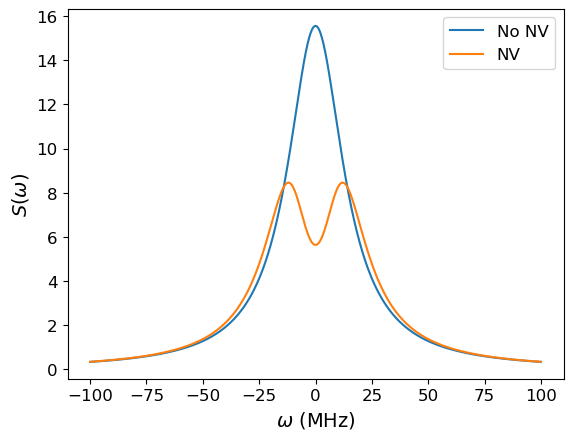

In [17]:
plt.plot(10*ω_bounds / 1e0, no_NV_spectrum, label='No NV')
plt.plot(10*ω_bounds / 1e0, NV_spectrum, label='NV')
plt.xlabel("$\\omega$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

Let's try sweeping over $\kappa$ and $\phi$ for different values of $g$ and $r$ to see if there's some point where the NV ensemble outperforms the bare cavity.

In [18]:
# Define g and r
g = γ
r = 2 * g

# Define sweeping parameters
κ = np.linspace(1, 100, 100)
ϕ = np.linspace(1, 100, 100)
κm, ωm, ϕm = np.meshgrid(κ, ω_bounds, ϕ)

In [19]:
noise_no_nv, signal_no_nv, temp = get_photons_e_no_NV(ωm, κm, γ, ϕm, 0, 0, nT, β, 0)
noise, signal, temp = get_photons_e(ωm, κm, γ, ϕm, g, r, 0, 0, nT, nc, β, 0)

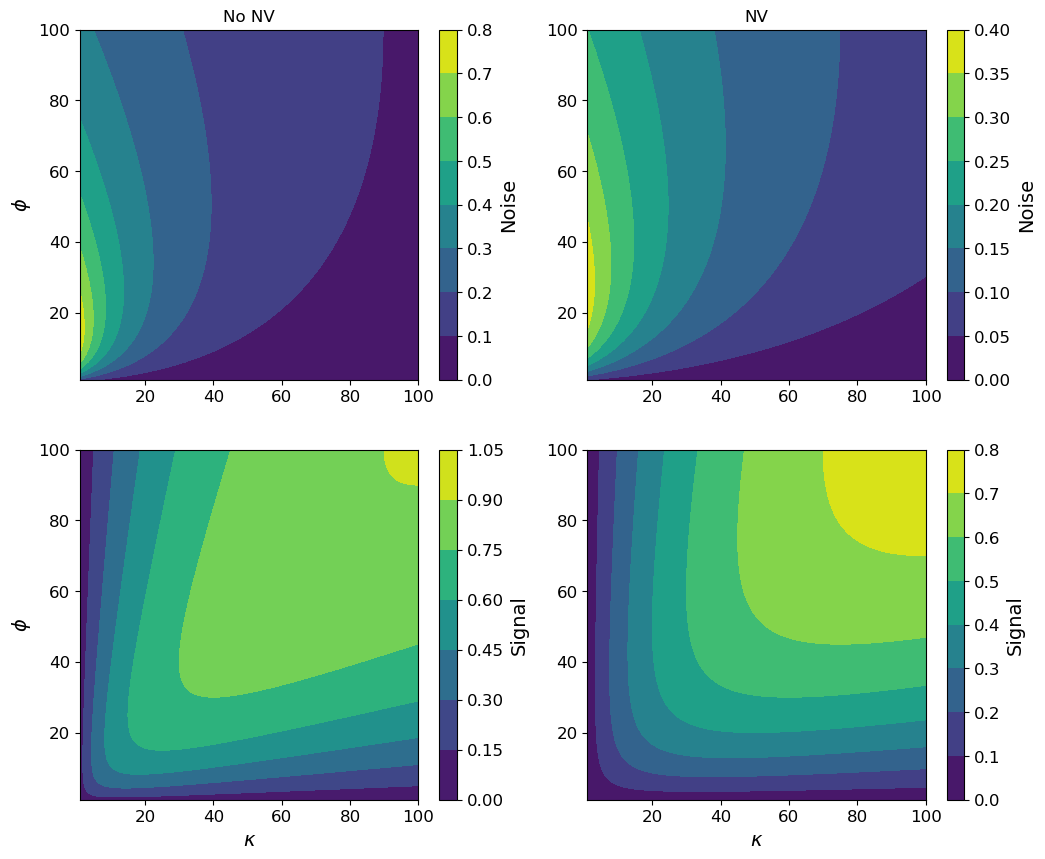

In [20]:
fig = plt.figure(1, figsize=(12, 10))
ax = fig.subplots(2, 2)
im00 = ax[0][0].contourf(κm[0], ϕm[0], noise_no_nv / expected_noise)
ax[0][0].set_ylabel("$\\phi$")
ax[0][0].set_title("No NV")
fig.colorbar(im00, label='Noise')

im01 = ax[0][1].contourf(κm[0], ϕm[0], noise / expected_noise)
ax[0][1].set_title("NV")
fig.colorbar(im01, label='Noise')

im10 = ax[1][0].contourf(κm[0], ϕm[0], signal_no_nv[0] / input_signal)
ax[1][0].set_ylabel("$\\phi$")
ax[1][0].set_xlabel("$\\kappa$")
fig.colorbar(im10, label='Signal')

im11 = ax[1][1].contourf(κm[0], ϕm[0], signal[0] / input_signal)
ax[1][1].set_xlabel("$\\kappa$")
fig.colorbar(im11, label='Signal')

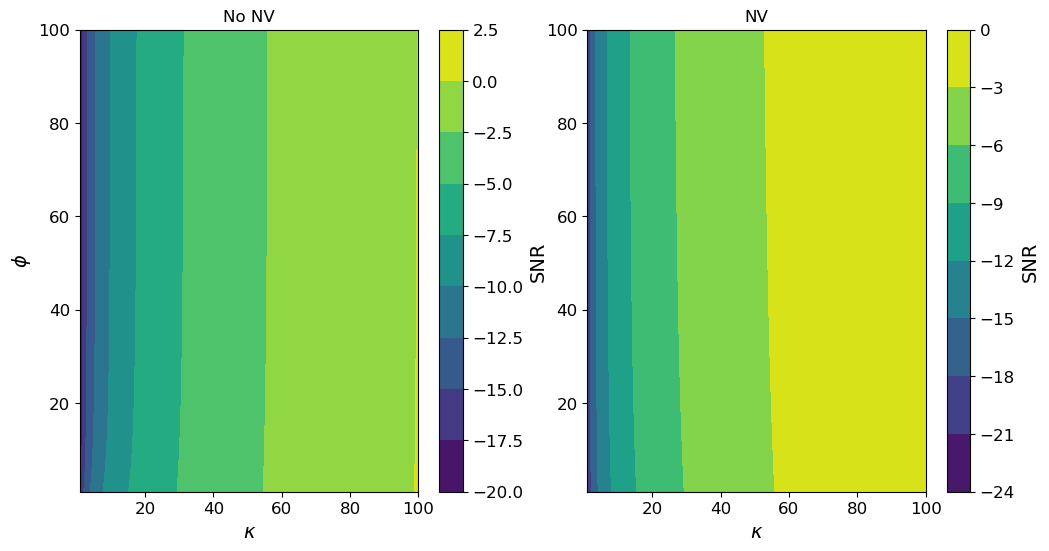

In [21]:
fig = plt.figure(1, figsize=(12, 6))
ax = fig.subplots(1, 2)
im0 = ax[0].contourf(κm[0], ϕm[0], 10*np.log10(signal_no_nv[0] / noise_no_nv))
ax[0].set_xlabel("$\\kappa$")
ax[0].set_ylabel("$\\phi$")
ax[0].set_title("No NV")
fig.colorbar(im0, label='SNR')

im1 = ax[1].contourf(κm[0], ϕm[0], 10*np.log10(signal[0] / noise))
ax[1].set_xlabel("$\\kappa$")
ax[1].set_title("NV")
fig.colorbar(im1, label='SNR')

Repeat for $g, r$ closer to the max values of $\kappa, \phi$

In [22]:
g = 100
r = 2 * g

In [23]:
noise_no_nv, signal_no_nv, temp = get_photons_e_no_NV(ωm, κm, γ, ϕm, 0, 0, nT, β, 0)
noise, signal, temp = get_photons_e(ωm, κm, γ, ϕm, g, r, 0, 0, nT, nc, β, 0)

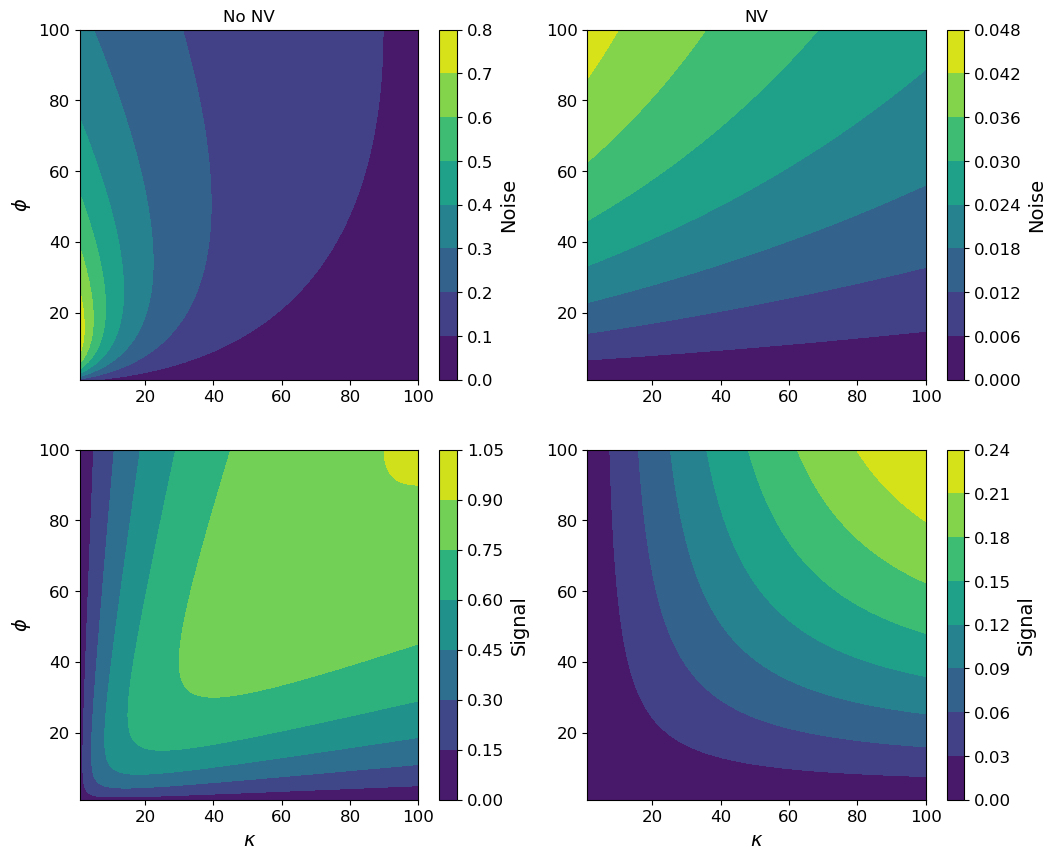

In [24]:
fig = plt.figure(1, figsize=(12, 10))
ax = fig.subplots(2, 2)
im00 = ax[0][0].contourf(κm[0], ϕm[0], noise_no_nv / expected_noise)
ax[0][0].set_ylabel("$\\phi$")
ax[0][0].set_title("No NV")
fig.colorbar(im00, label='Noise')

im01 = ax[0][1].contourf(κm[0], ϕm[0], noise / expected_noise)
ax[0][1].set_title("NV")
fig.colorbar(im01, label='Noise')

im10 = ax[1][0].contourf(κm[0], ϕm[0], signal_no_nv[0] / input_signal)
ax[1][0].set_ylabel("$\\phi$")
ax[1][0].set_xlabel("$\\kappa$")
fig.colorbar(im10, label='Signal')

im11 = ax[1][1].contourf(κm[0], ϕm[0], signal[0] / input_signal)
ax[1][1].set_xlabel("$\\kappa$")
fig.colorbar(im11, label='Signal')

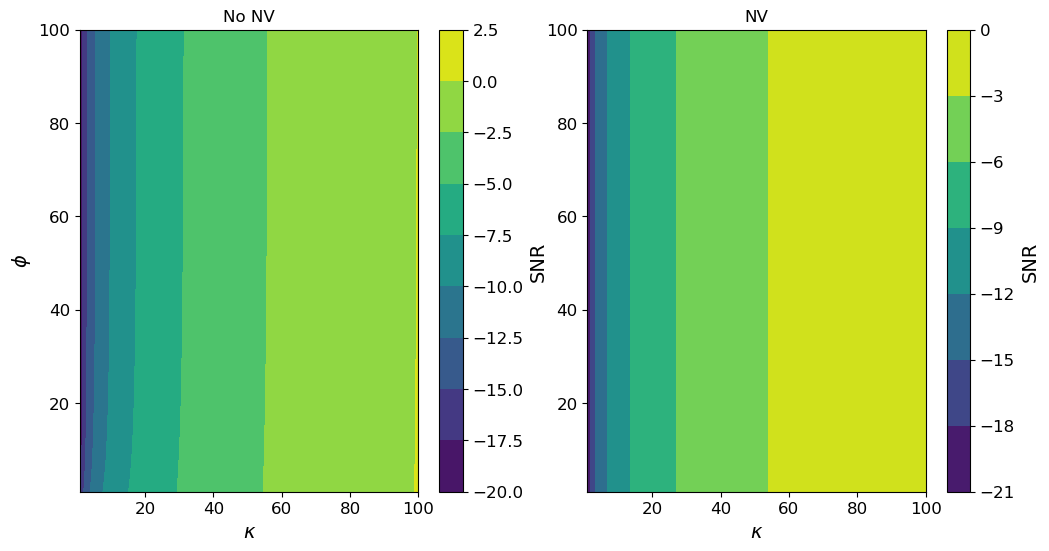

In [25]:
fig = plt.figure(1, figsize=(12, 6))
ax = fig.subplots(1, 2)
im0 = ax[0].contourf(κm[0], ϕm[0], 10*np.log10(signal_no_nv[0] / noise_no_nv))
ax[0].set_xlabel("$\\kappa$")
ax[0].set_ylabel("$\\phi$")
ax[0].set_title("No NV")
fig.colorbar(im0, label='SNR')

im1 = ax[1].contourf(κm[0], ϕm[0], 10*np.log10(signal[0] / noise))
ax[1].set_xlabel("$\\kappa$")
ax[1].set_title("NV")
fig.colorbar(im1, label='SNR')

Repeat for $g, r \gg \kappa,\phi$

In [26]:
g = 1000
r = 2 * g

In [27]:
noise_no_nv, signal_no_nv, temp = get_photons_e_no_NV(ωm, κm, γ, ϕm, 0, 0, nT, β, 0)
noise, signal, temp = get_photons_e(ωm, κm, γ, ϕm, g, r, 0, 0, nT, nc, β, 0)

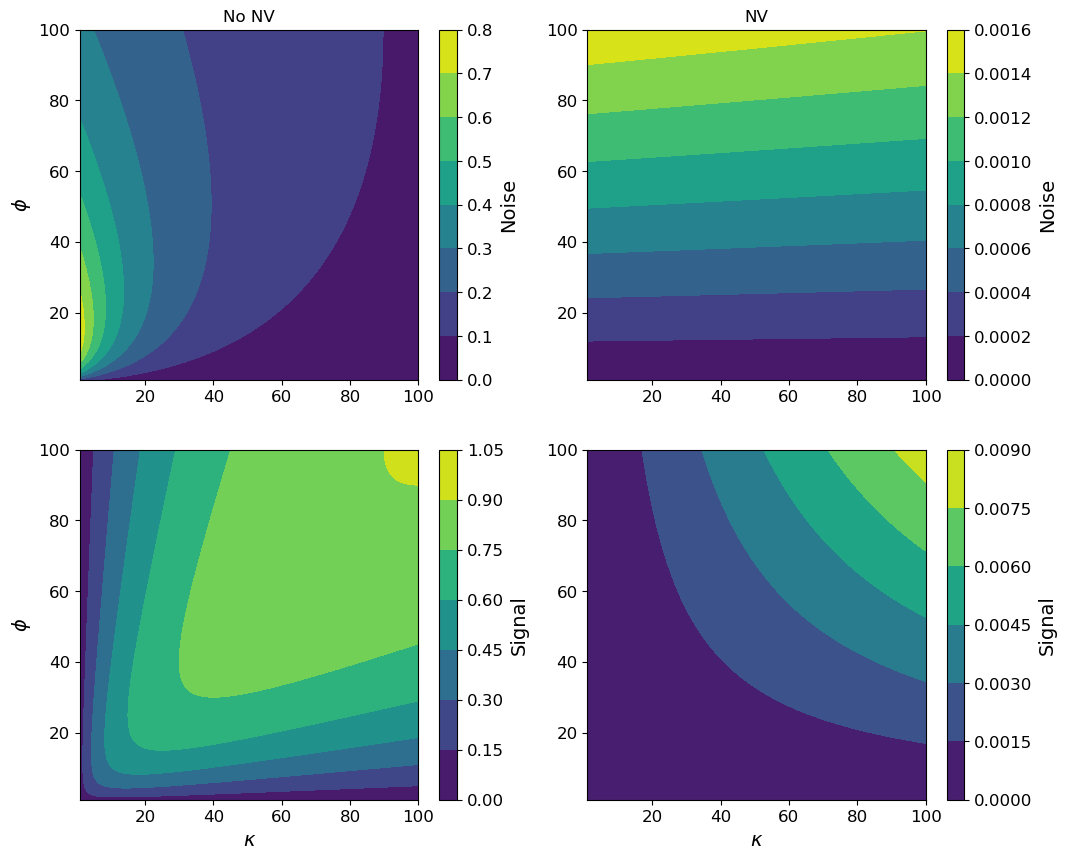

In [28]:
fig = plt.figure(1, figsize=(12, 10))
ax = fig.subplots(2, 2)
im00 = ax[0][0].contourf(κm[0], ϕm[0], noise_no_nv / expected_noise)
ax[0][0].set_ylabel("$\\phi$")
ax[0][0].set_title("No NV")
fig.colorbar(im00, label='Noise')

im01 = ax[0][1].contourf(κm[0], ϕm[0], noise / expected_noise)
ax[0][1].set_title("NV")
fig.colorbar(im01, label='Noise')

im10 = ax[1][0].contourf(κm[0], ϕm[0], signal_no_nv[0] / input_signal)
ax[1][0].set_ylabel("$\\phi$")
ax[1][0].set_xlabel("$\\kappa$")
fig.colorbar(im10, label='Signal')

im11 = ax[1][1].contourf(κm[0], ϕm[0], signal[0] / input_signal)
ax[1][1].set_xlabel("$\\kappa$")
fig.colorbar(im11, label='Signal')

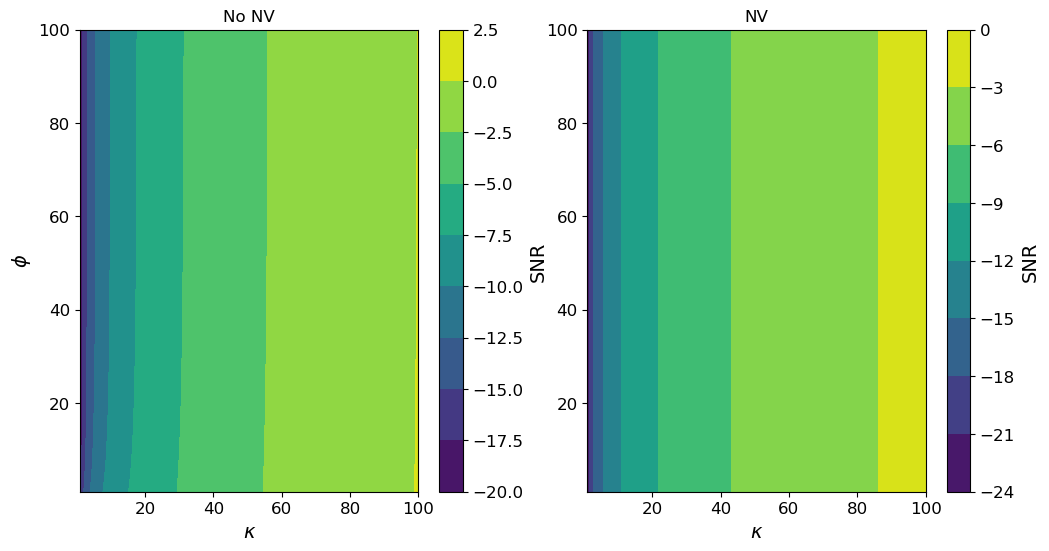

In [29]:
fig = plt.figure(1, figsize=(12, 6))
ax = fig.subplots(1, 2)
im0 = ax[0].contourf(κm[0], ϕm[0], 10*np.log10(signal_no_nv[0] / noise_no_nv))
ax[0].set_xlabel("$\\kappa$")
ax[0].set_ylabel("$\\phi$")
ax[0].set_title("No NV")
fig.colorbar(im0, label='SNR')

im1 = ax[1].contourf(κm[0], ϕm[0], 10*np.log10(signal[0] / noise))
ax[1].set_xlabel("$\\kappa$")
ax[1].set_title("NV")
fig.colorbar(im1, label='SNR')

How does this change with bandwidth?

In [30]:
g = 10
r = 2 * g
Q = 10
γ = 10
κ = 10
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = 35#photons_from_temp(ωc, T)
ϕ = κ
β = np.sqrt(70)

# Set the power spectral density for the phase noise to a constant - we'll use nT for now
Sϕ = nT * np.ones(ω_bounds.shape[0])
dω = np.logspace(-3, 2, 1000)

In [31]:
noise_no_NV = np.zeros(dω.shape[0])
signal_no_NV = np.zeros(dω.shape[0])
noise = np.zeros(dω.shape[0])
signal = np.zeros(dω.shape[0])

for i, w in enumerate(dω):
    ω_bounds = np.linspace(-w, w, 1000)
    noise_no_NV[i], signal_no_NV[i], temp = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, 0, 0, nT, β, 0)
    noise[i], signal[i], temp = get_photons_e(ω_bounds, κ, γ, ϕ, g, r, 0, 0, nT, nc, β, 0)

Text(0.5, 1.0, 'SNR')

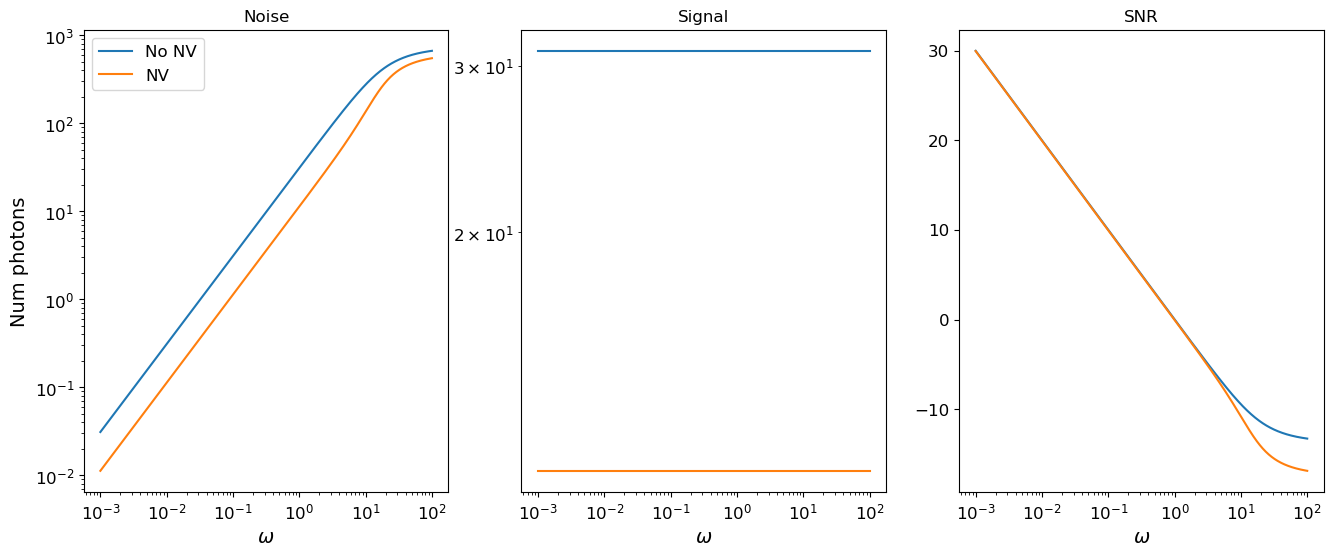

In [32]:
fig = plt.figure(1, figsize=(16, 6))
ax = fig.subplots(1, 3)
ax[0].loglog(dω, noise_no_NV, label='No NV')
ax[0].loglog(dω, noise, label='NV')
ax[0].set_xlabel("$\\omega$")
ax[0].set_ylabel("Num photons")
ax[0].set_title("Noise")
ax[0].legend()

ax[1].loglog(dω, signal_no_NV)
ax[1].loglog(dω, signal)
ax[1].set_xlabel("$\\omega$")
ax[1].set_title("Signal")

ax[2].semilogx(dω, 10*np.log10(signal_no_NV / noise_no_NV))
ax[2].semilogx(dω, 10*np.log10(signal / noise))
ax[2].set_xlabel("$\\omega$")
ax[2].set_title("SNR")

Matt suggested that we try and normalize the SNR by the attenuation factor to get a better comparison between the bare cavity attenuation and the attenuation of the system with the NV ensemble.  In other words, its sort of looking at what the SNR is for a given attenuation.  I think it makes the most sense to use the attenuation of the noise for this, as that's what we want to attenuate with mode cooling in the first place.  In that case, we can define the attenuation factor as $G = \frac{n_{out}}{n_{in}}$ where $n_{out}$ is the number of noise photons in the output (i.e. the integral of the noise part of the output spectrum over a given bandwidth) and $n_{in}$ is the number of photons that would be present if there was no cavity at all.

In [33]:
# Define our parameters
κ = 10
γ = 10
ϕ = 10
g = 10
r = 2 * g
nT = 35
ω_bounds = np.linspace(-γ, γ, 1000)

In [34]:
# Bare cavity calculation
n_in_bc = 2 * ω_bounds[-1] * nT

n_out_bc, sig_bc, temp = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, 0, 0, nT, β, 0)

G_bc = n_out_bc / n_in_bc

SNR_bc = sig_bc / n_out_bc

print("Gain : ", G_bc)
print("SNR: ", SNR_bc)
print("SNR / Gain: ", SNR_bc / G_bc)

Gain :  0.39200173569849295
SNR:  0.1133781827910802
SNR / Gain:  0.2892287774926709


In [35]:
n_in_nv = 2 * ω_bounds[-1] * (nT + nc)

n_out_nv, sig_nv, temp = get_photons_e(ω_bounds, κ, γ, ϕ, g, r, 0, 0, nT, nc, β, 0)

G_nv = n_out_nv / n_in_nv

SNR_nv = sig_nv / n_out_nv

print("Gain: ", G_nv)
print("SNR: ", SNR_nv)
print("SNR / Gain: ", SNR_nv / G_nv)

Gain:  0.19233668004996352
SNR:  0.08289141984814907
SNR / Gain:  0.4309704203411241


Dummy work

In [52]:
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
g = 2 * np.pi * 197.7e3
r = 2 * np.pi * 229e3
T = 290
nT = photons_from_temp(ωc, T)
P = 0.8
nc = 0.5 * (1 - P) / P

In [53]:
ω_bounds = 2 * np.pi * np.linspace(-1.5, 1.5, 1000) * 1e6
Sa = get_spectrum_a(ω_bounds, κ, γ, 0, g, r, nT, nc, 0)

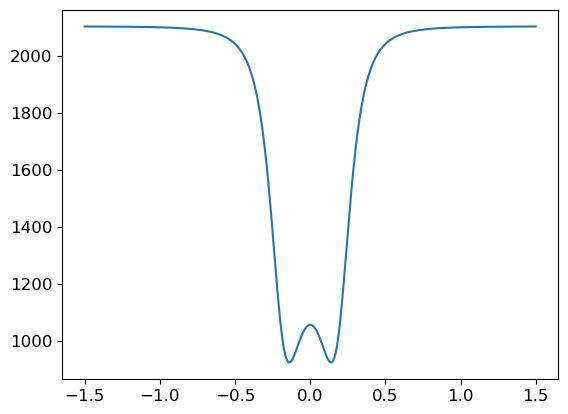

In [54]:
plt.plot(ω_bounds / (2 * np.pi * 1e6), Sa)

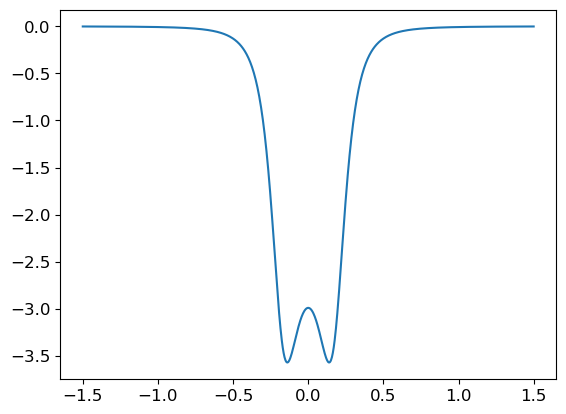

In [66]:
Pa = 10*np.log10(Sa / nT)
plt.plot(ω_bounds / (2 * np.pi * 1e6), Pa)

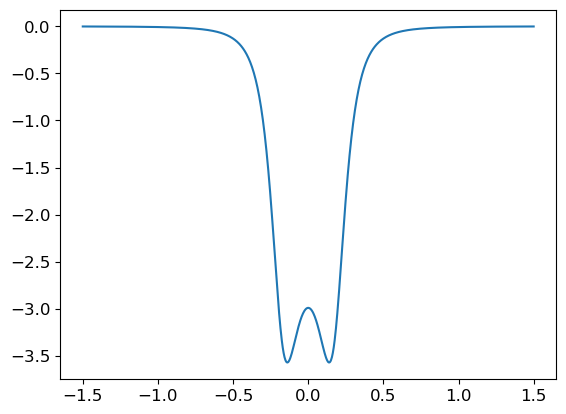

In [73]:
test_Sa = test(ω_bounds, κ, γ, g, r, nT, nc)
test_Pa = 10 * np.log10(Sa / nT)
plt.plot(ω_bounds / (2 * np.pi * 1e6), test_Pa)